# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [5]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [6]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [8]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [9]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [11]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [15]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)
final=final.sort_values(by=['Time'])
final = final.reset_index(drop=True)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()
final.head(10)

(87773, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...
1,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
2,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
3,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe..."
4,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...
5,66610,B0000SY9U4,A3EEDHNHI4WNSH,Joanna J. Young,23,23,1,1067472000,Yummy,"If you've never tried Kona coffee, Aloha Islan..."
6,42069,B0000EIEQU,A1YMJX4YWCE6P4,"Jim Carson ""http://www.jimcarson.com""",12,12,1,1067558400,These limes rule!,"Fresh limes are underappreciated, but a joy to..."
7,42227,B0000A0BS8,A1IU7S4HCK1XK0,Joanna Daneman,5,5,1,1067644800,I gave up on other coffees,The grocery store has all kinds of &quot;gourm...
8,42226,B0000A0BS8,A23GFTVIETX7DS,Debbie Lee Wesselmann,5,5,1,1067904000,Five stars if you like Starbucks,This blend is one of Starbucks' gentler blends...
9,11991,B0000T15M8,A2928LJN5IISB4,chatchi,5,5,1,1067990400,The fruits of my labor,When chatchi's favorite afternoon treat became...


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
I have made these brownies for family and for a den of cub scouts and no one would have known they were gluten free and everyone asked for seconds!  These brownies have a fudgy texture and have bits of chocolate chips in them which are delicious.  I would say the mix is very thick and a little difficult to work with.  The cooked brownies are slightly difficult to cut into very neat edges as the edges tend to crumble a little and I would also say that they make a slightly thinner layer of brownies than most of the store brand gluten containing but they taste just as good, if not better.  Highly recommended!<br /><br />(For those wo

In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had "attracted" many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
I have made these brownies for family and for a den of cub scouts and no one would have known they were gluten free and everyone asked for seconds!  These brownies have a fudgy texture and have bits of chocolate chips in them which are delicious.  I would say the mix is very thick and a little difficult to work with.  The cooked brownies are slightly difficult to cut into very neat edges as the edges tend to crumble a little and I would also say that they make a slightly thinner layer of brownies than most of the store brand gluten containing but they taste just as good, if not better.  Highly recommended!(For those wondering, this mix requ

In [20]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This gum is my absolute favorite. By purchasing on amazon I can get the savings of large quanities at a very good price. I highly recommend to all gum chewers. Plus as you enjoy the peppermint flavor and freshing of breath you are whitening your teeth all at the same time.


In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This gum is my absolute favorite By purchasing on amazon I can get the savings of large quanities at a very good price I highly recommend to all gum chewers Plus as you enjoy the peppermint flavor and freshing of breath you are whitening your teeth all at the same time 


In [24]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:37<00:00, 2342.03it/s]


In [26]:
preprocessed_reviews[1500]

'gum absolute favorite purchasing amazon get savings large quanities good price highly recommend gum chewers plus enjoy peppermint flavor freshing breath whitening teeth time'

In [27]:
Score=final.Score
Score.shape

(87773,)

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

In [28]:
from sklearn.model_selection import train_test_split
import math

preprocessed_reviews=np.array(preprocessed_reviews)

def splitter(X,Y):
  
  X_train =  X[:int(math.ceil(Y.shape[0])*.7)] 
  X_test = X[int(math.ceil(Y.shape[0])*.7):]
  y_train = Y[:int(math.ceil(Y.shape[0])*.7)]
  y_test =  Y[int(math.ceil(Y.shape[0])*.7):]
  return (X_train, X_test, y_train, y_test)

def random_splitter(X,Y):
  
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
  return (X_train, X_test, y_train, y_test)

In [29]:

TRAIN,TEST,Y_TRAIN,Y_TEST=splitter(preprocessed_reviews,Score)

print("Number of data points for TRAIN:",TRAIN.shape[0])
print("Number of data points for TEST",TEST.shape[0])
print("Number of data points for Y_TRAIN",Y_TRAIN.shape[0])
print("Number of data points for Y_TEST",Y_TEST.shape[0])

Number of data points for TRAIN: 61441
Number of data points for TEST 26332
Number of data points for Y_TRAIN 61441
Number of data points for Y_TEST 26332


# [4] Featurization

## [4.1] BAG OF WORDS

In [30]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(TRAIN)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(TRAIN)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (61441, 45807)
the number of unique words  45807


In [31]:
final_counts_test = count_vect.transform(TEST)

## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect_bi = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect_bi.fit_transform(TRAIN)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (61441, 5000)
the number of unique words including both unigrams and bigrams  5000


In [0]:
final_bigram_counts_test = count_vect.transform(TEST)

## [4.3] TF-IDF

In [91]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(TRAIN)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(TRAIN)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (61441, 36173)
the number of unique words including both unigrams and bigrams  36173


In [92]:
final_tf_idf_test = tf_idf_vect.transform(TEST)

## [4.4] Word2Vec

In [97]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in TRAIN:
    list_of_sentance.append(sentance.split())

In [101]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8276865482330322), ('fantastic', 0.8175984621047974), ('awesome', 0.8139568567276001), ('terrific', 0.7959204316139221), ('excellent', 0.7948600053787231), ('wonderful', 0.7847779393196106), ('perfect', 0.7493413090705872), ('fabulous', 0.7331421971321106), ('decent', 0.7270404100418091), ('amazing', 0.7161839604377747)]
[('greatest', 0.7828863263130188), ('best', 0.7433225512504578), ('nastiest', 0.7377063632011414), ('coolest', 0.6903956532478333), ('tastiest', 0.6870601177215576), ('shiniest', 0.6364575624465942), ('disgusting', 0.6282263994216919), ('closest', 0.6154747009277344), ('ive', 0.6127970218658447), ('humble', 0.5993553996086121)]


In [102]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14799
sample words  ['single', 'completely', 'grocer', 'shopped', 'pun', 'alluring', 'sauced', 'sustain', 'otherwise', 'heavens', 'layered', 'senna', 'zippy', 'tinny', 'representative', 'coffee', 'cupboard', 'powdering', 'bouts', 'ichiban', 'mentioned', 'embarrassed', 'pearled', 'assistance', 'coax', 'involved', 'staring', 'fore', 'singers', 'slimey', 'flushed', 'downs', 'carte', 'indigestible', 'elated', 'aspects', 'hygiene', 'knee', 'agressive', 'tuck', 'fritos', 'organically', 'choy', 'almonds', 'rachael', 'fizz', 'tastewise', 'balsamic', 'stations', 'cosmic']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [118]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 61441/61441 [15:23<00:00, 66.51it/s] 

61441
50


In [125]:
list_of_sentance_test=[]
for sentance in TEST:
    list_of_sentance_test.append(sentance.split())

In [126]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))

100%|██████████| 26332/26332 [05:51<00:00, 74.92it/s] 

26332


#### [4.4.1.2] TFIDF weighted W2v

In [103]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(TRAIN)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [104]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 61441/61441 [50:59<00:00, 20.09it/s]  


In [107]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)

100%|██████████| 26332/26332 [22:20<00:00, 19.65it/s] 


# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

In [ ]:
! pip install scikit-plot

In [143]:
#def  function
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sn
import math
import time
import scikitplot as skplt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

depth=[1, 5, 10, 50, 100, 500, 100]
min_samples_split=[5, 10, 100, 500]
       


#HYPERPARAMETER TUNING


def best_param(data):
        clf = DecisionTreeClassifier(class_weight="balanced")
        
        parameters= {'max_depth':[1, 5, 10, 50, 100, 500, 1000],'min_samples_split':[5, 10, 100, 500]}

        model=GridSearchCV(clf,parameters,cv=5,scoring='roc_auc',n_jobs=-1)
   
        model.fit(data[0],data[1])
   
        print("Best param:",model.best_params_)
        print("Best AUC-score:",model.best_score_*100)
        df1 = pd.DataFrame(model.cv_results_)
  
 
        return df1 

####################################################################################################################################################

def dec_tree(data,i,j):
    
    clf = DecisionTreeClassifier(max_depth=i, min_samples_split=j,class_weight="balanced")
        
    clf.fit(data[0],data[1])
    
    pred1=clf.predict_proba(data[0])[:,1]
    pred2=clf.predict_proba(data[2])[:,1]

    score1=roc_auc_score(data[1],pred1)
    score2=roc_auc_score(data[3],pred2)  
    
    
    pred2=np.round_(pred2)
    
  
    matrix=confusion_matrix(data[3],pred2)
    df=pd.DataFrame(matrix,index=['Positive','Negative'],columns=['Positive','Negative'])
    plt.figure(figsize = (10,7))
    sn.heatmap(df, annot=True,fmt='g')
    
    
    print()

    fpr1, tpr1, thresholds1 = roc_curve(data[1],pred1)
    fpr2, tpr2, thresholds2 = roc_curve(data[3],pred2)
  

    plt.figure()
    plt.plot(fpr1, tpr1, color='darkorange', lw=1, label='ROC curve Training (area = %0.2f)' % score1)
    plt.plot(fpr2, tpr2, color='red', lw=1, label='ROC curve Test (area = %0.2f)' % score2)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return score2,clf
 

In [73]:
def heat_maps(df,type):
    x=df[['param_max_depth','param_min_samples_split','mean_test_score','mean_train_score']]
    if(type=="cross"):
        row1=x[x.param_min_samples_split==5].mean_test_score
        row2=x[x.param_min_samples_split==10].mean_test_score
        row3=x[x.param_min_samples_split==100].mean_test_score
        row4=x[x.param_min_samples_split==500].mean_test_score
    else:
        row1=x[x.param_min_samples_split==5].mean_train_score
        row2=x[x.param_min_samples_split==10].mean_train_score
        row3=x[x.param_min_samples_split==100].mean_train_score
        row4=x[x.param_min_samples_split==500].mean_train_score
    matrix=np.vstack((row1,row2,row3,row4))
    y=pd.DataFrame(matrix,index=[5,10,100,500],columns=[1, 5, 10, 50, 100, 500, 1000])
    plt.figure(figsize = (10,7))
    ax=sn.heatmap(y, annot=True,fmt='g')
    if type=="cross":
        plt.title("Cross Validation AUC score for Depth and minimun_samples_split")
    else:
        plt.title("Training AUC score for Depth and minimun_samples_split")
    plt.xlabel("Depth value")
    plt.ylabel("minimun_samples_split")

# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [62]:
data=(final_counts,Y_TRAIN)
df=best_param(data)

Best param: {'max_depth': 50, 'min_samples_split': 500}
Best AUC-score: 80.61991300936083


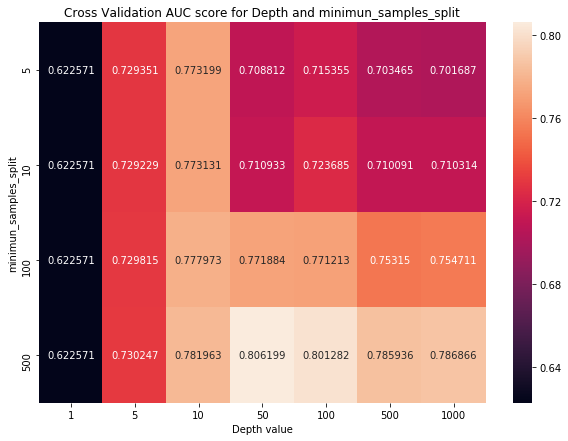

In [74]:
heat_maps(df,"cross")

WE SEE THAT THE MAXIMUM CROSS VALIDATION AUC SCORE IS FOR MIN_SPLIT =500 AND DEPTH OF 50

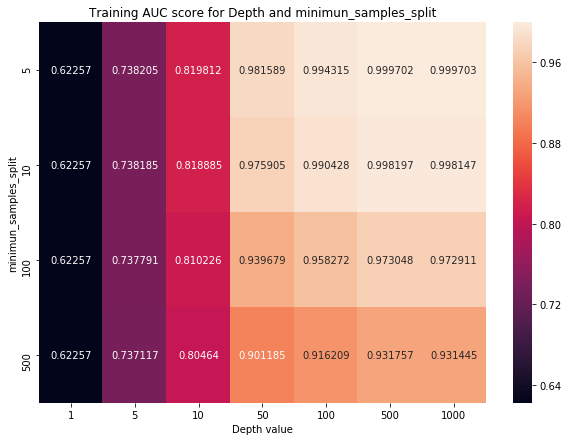

In [75]:
heat_maps(df,"train")

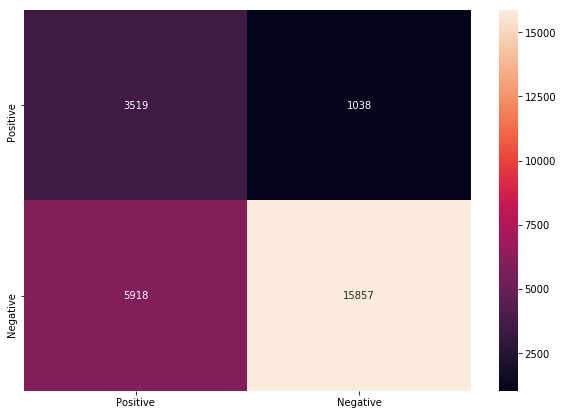

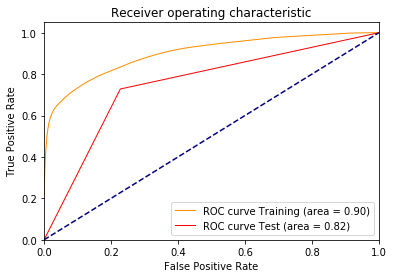

In [144]:

data=(final_counts,Y_TRAIN,final_counts_test,Y_TEST)
x=dec_tree(data,50,500)

In [145]:
print("The AUC score for BOW for depth={} and min_split={} : {}".format(50,500,x[0]))

The AUC score for BOW for depth=50 and min_split=500 : 0.8197496792131912


### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [113]:

def most_informative_feature_for_binary_classification(vectorizer, classifier):
    feature_names = vectorizer.get_feature_names()
    coefs = sorted(zip(classifier.feature_importances_, feature_names))
   
    topn_class = coefs[:-(21):-1]
    print("************************")
    print("Top 20 most imporant features")
    for i in topn_class:
      print(i)

most_informative_feature_for_binary_classification(count_vect,x[1])

************************
Top 20 most imporant features
(0.13892149239493348, 'janes')
(0.09530089717295255, 'experiance')
(0.0381366707911856, 'auditors')
(0.037835673102218303, 'cockroaches')
(0.030100300622339347, 'harris')
(0.027169206616435456, 'equitably')
(0.025166835015621933, 'macroonisadly')
(0.021720480301934773, 'applause')
(0.020922455750683765, 'heaves')
(0.020695645007360486, 'completey')
(0.015646827226749847, 'ironman')
(0.014461203966272693, 'delish')
(0.014045153806679408, 'darjeelings')
(0.012524232083205427, 'seed')
(0.012397871716449793, 'rajastan')
(0.009513071900667965, 'mia')
(0.009272790116770435, 'corndog')
(0.00883111503526325, 'restraunt')
(0.008615314863036523, 'noblesse')
(0.007541749070100259, 'progressing')


In [ ]:
! pip install pydotplus --upgrade

### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

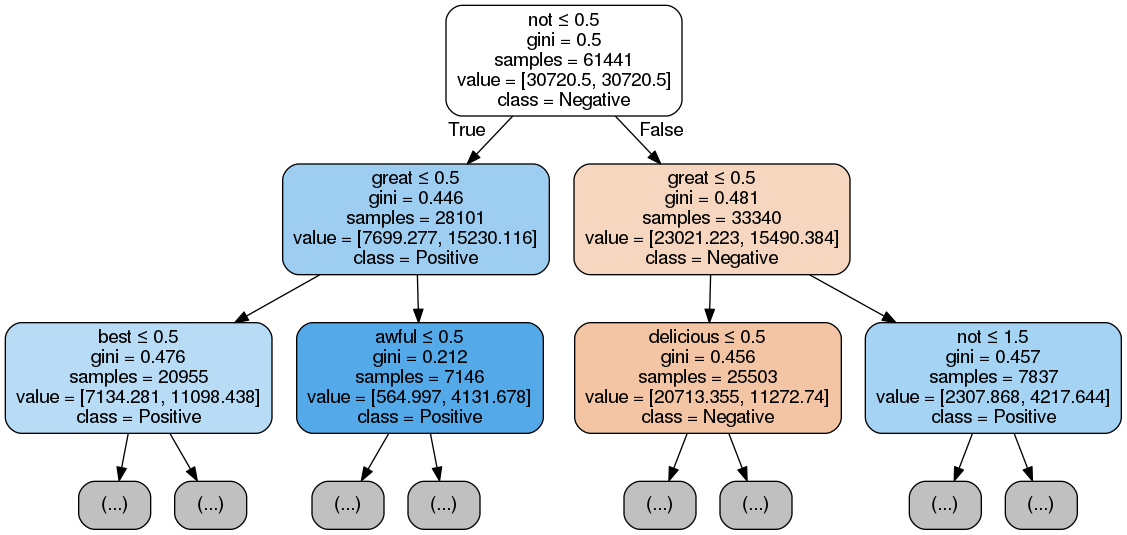

In [89]:

from sklearn import tree
import pydotplus
from sklearn import tree
import collections
from sklearn.tree.export import export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO



dot_data=StringIO()

export_graphviz(x[1],max_depth=2,feature_names=count_vect.get_feature_names(),filled=True,rounded=True,special_characters=True,class_names=['Negative','Positive'],out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

graph.create_png()

Image(graph.create_png())



## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [109]:

data=(final_tf_idf,Y_TRAIN)
param=best_param(data)

Best param: {'max_depth': 50, 'min_samples_split': 500}
Best AUC-score: 80.63089415252857


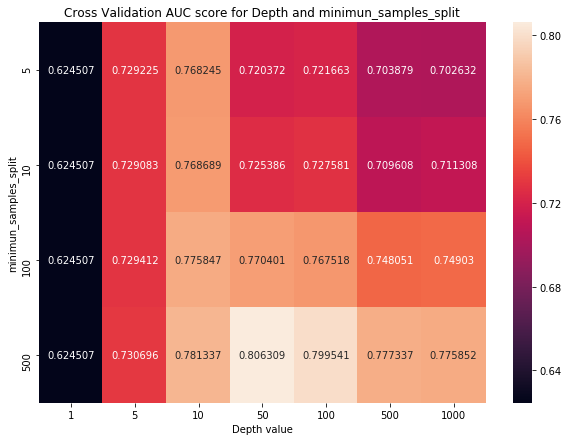

In [110]:
heat_maps(param,"cross")

WE SEE THAT THE MAXIMUM CROSS VALIDATION AUC SCORE IS FOR MIN_SPLIT =500 AND DEPTH OF 50

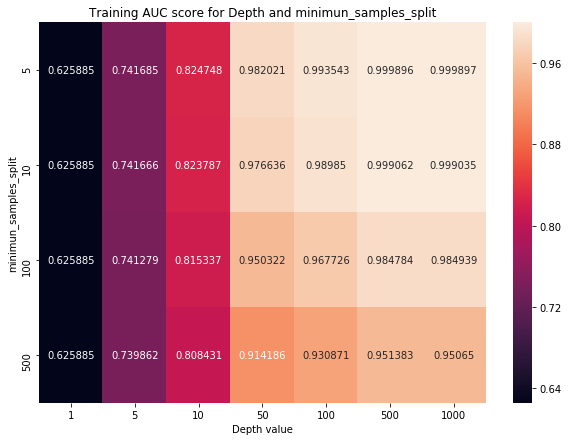

In [111]:
heat_maps(param,"train")

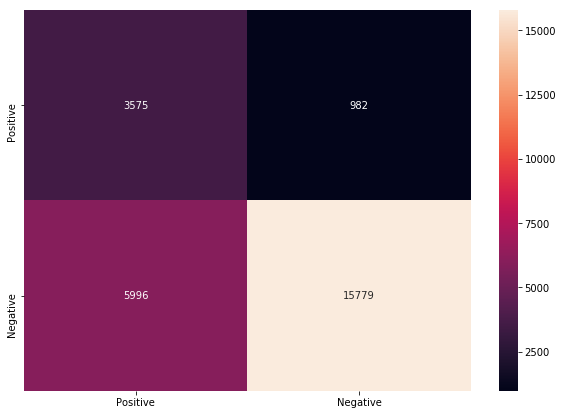

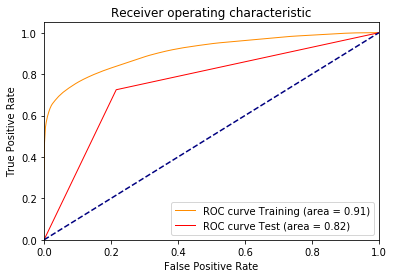

In [146]:
data=(final_tf_idf,Y_TRAIN,final_tf_idf_test,Y_TEST)
x=dec_tree(data,50,500)

In [148]:
print("The AUC score for BOW for depth={} and min_split={} : {}".format(50,500,x[0]))

The AUC score for BOW for depth=50 and min_split=500 : 0.8167481526887264


### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [135]:

def most_informative_feature_for_binary_classification(vectorizer, classifier):
    feature_names = vectorizer.get_feature_names()
    coefs = sorted(zip(classifier.feature_importances_, feature_names))
   
    topn_class = coefs[:-(21):-1]
    print("************************")
    print("Top 20 most imporant features")
    for i in topn_class:
      print(i)

most_informative_feature_for_binary_classification(tf_idf_vect,x[1])

************************
Top 20 most imporant features
(0.1387015569457895, 'not')
(0.09515002026210663, 'great')
(0.03807629420240245, 'best')
(0.03777577304202905, 'delicious')
(0.030052646922241008, 'love')
(0.027139794707744063, 'good')
(0.025126991798659556, 'perfect')
(0.02168609322827599, 'bad')
(0.020706947851102893, 'loves')
(0.020662880415633463, 'disappointed')
(0.015622055739536731, 'nice')
(0.014438309514623765, 'favorite')
(0.014022918030509408, 'excellent')
(0.012501207070519757, 'wonderful')
(0.012378243857308287, 'thought')
(0.009498011151571837, 'product')
(0.009258109773058475, 'easy')
(0.008837716176763915, 'unfortunately')
(0.008601675410198559, 'reviews')
(0.007583633930927407, 'not good')


### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

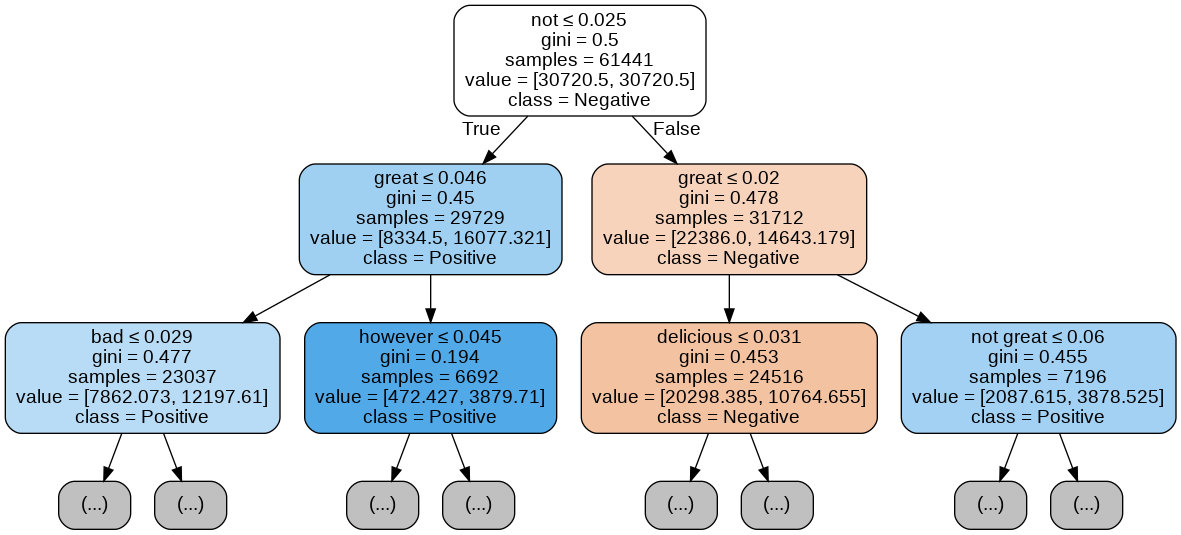

In [0]:
dot_data=StringIO()

export_graphviz(x[1],max_depth=2,feature_names=tf_idf_vect.get_feature_names(),filled=True,rounded=True,special_characters=True,class_names=['Negative','Positive'],out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

graph.create_png()

Image(graph.create_png())


## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [120]:
sent_vectors=np.array(sent_vectors)
data=(sent_vectors,Y_TRAIN)
df=best_param(data)

Best param: {'max_depth': 10, 'min_samples_split': 500}
Best AUC-score: 82.71122425829374


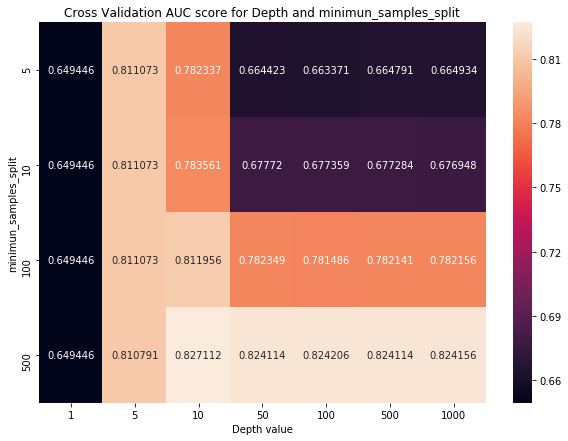

In [121]:
heat_maps(df,"cross")

WE SEE THAT THE MAXIMUM CROSS VALIDATION AUC SCORE IS FOR MIN_SPLIT =500 AND DEPTH OF 10

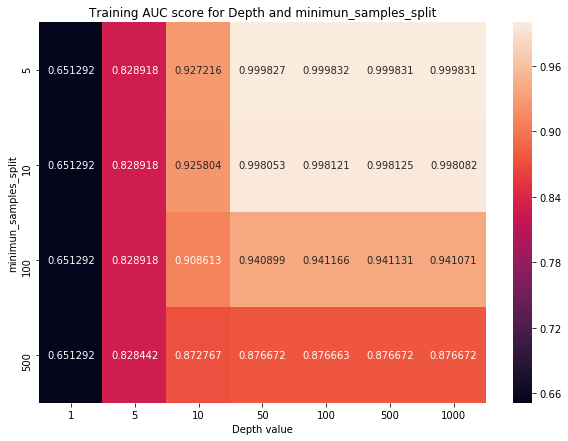

In [122]:
heat_maps(df,"train")

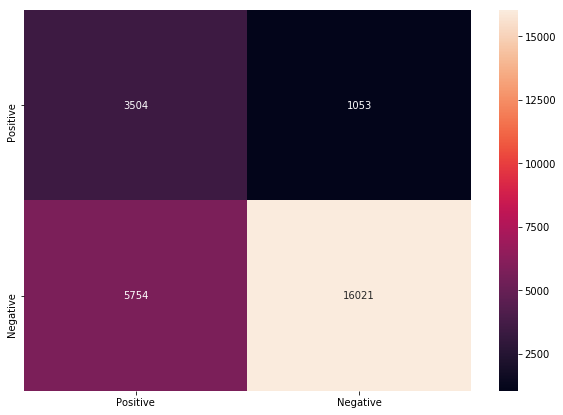

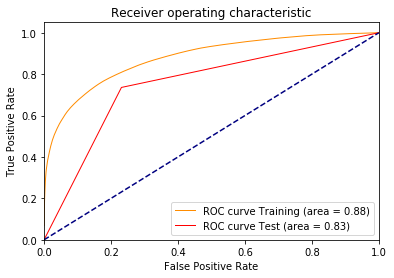

In [149]:
data=(sent_vectors,Y_TRAIN,sent_vectors_test,Y_TEST)
x=dec_tree(data,10,500)

In [150]:
print("The AUC score for depth={} and min_split={} : {}".format(10,500,x[0]))

The AUC score for depth=10 and min_split=500 : 0.8295305968763567


## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [130]:

data=(tfidf_sent_vectors,Y_TRAIN)
df=best_param(data)

Best param: {'max_depth': 10, 'min_samples_split': 500}
Best AUC-score: 80.16092008041875


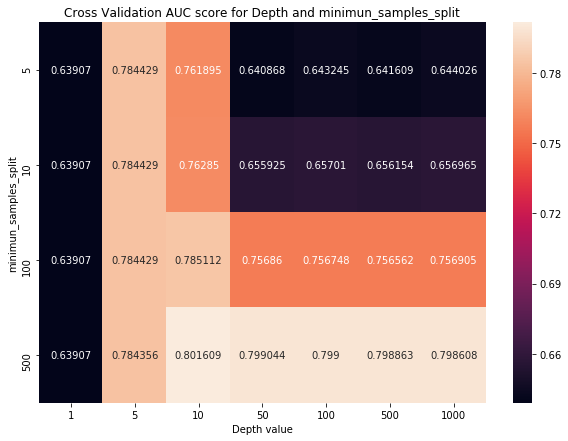

In [136]:
heat_maps(df,"cross")

WE SEE THAT THE MAXIMUM CROSS VALIDATION AUC SCORE IS FOR MIN_SPLIT =500 AND DEPTH OF 10

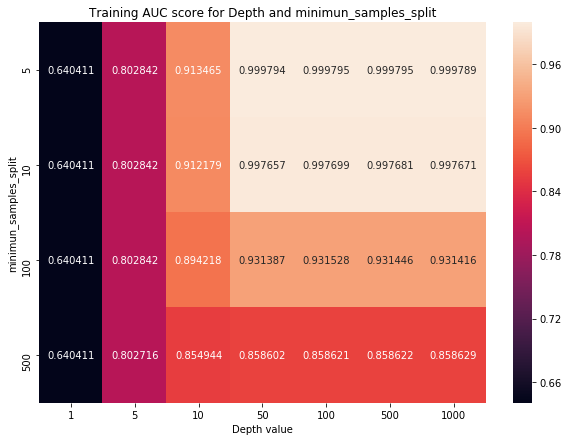

In [137]:
heat_maps(df,"train")

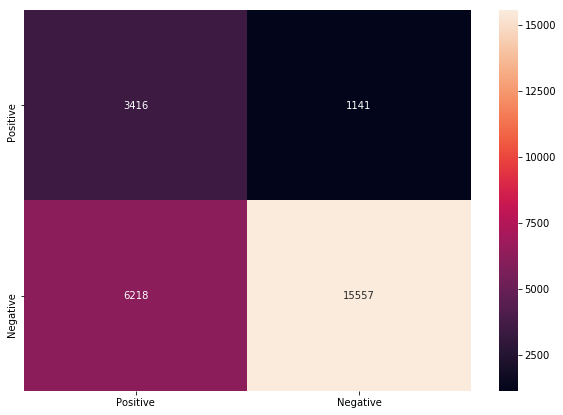

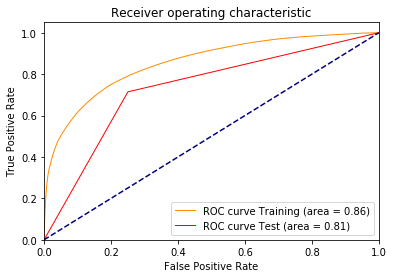

In [151]:
data=(tfidf_sent_vectors,Y_TRAIN,tfidf_sent_vectors_test,Y_TEST)
x=dec_tree(data,10,500)

In [152]:
print("The AUC score for depth={} and min_split={} : {}".format(10,500,x[0]))

The AUC score for depth=10 and min_split=500 : 0.8051473276248021


# [6] Conclusions

In [153]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model","Depth","Min_splits","AUC Score"]

x.add_row(["BOW","50","500","81.9%" ])
x.add_row(["TF-IDF","50","500","81.6%"])
x.add_row(["AVG WORD2VEC","10","500","82.9%" ])
x.add_row(["TF-IDF WORD2VEC","10","500","80.5%"])

  
print(x)  

+-----------------+-------+------------+-----------+
|      Model      | Depth | Min_splits | AUC Score |
+-----------------+-------+------------+-----------+
|       BOW       |   50  |    500     |   81.9%   |
|      TF-IDF     |   50  |    500     |   81.6%   |
|   AVG WORD2VEC  |   10  |    500     |   82.9%   |
| TF-IDF WORD2VEC |   10  |    500     |   80.5%   |
+-----------------+-------+------------+-----------+




1.   There is almost no variation in AUC scores for different vectorizers
2.   Similar vectorizers have the same number of depth and split for optimal performance
3.   The best vectorizer was AVG WORD2VEC with 82.9% AUC score

